In [ ]:
from urllib import request
import pandas as pd
import zipfile
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm_notebook
import tqdm

from torch.optim import SGD,Adam
from torch.nn import MSELoss
import torch.nn as nn
import matplotlib.pyplot as plt

In [ ]:
DATASET_URL = 'http://files.grouplens.org/datasets/movielens/ml-100k.zip'
DATASET_ARCHIVE = 'ml-100k.zip'

request.urlretrieve(DATASET_URL, DATASET_ARCHIVE)
with zipfile.ZipFile(DATASET_ARCHIVE) as archive:
    archive.extractall()

### Task 1

1. Go over the NCF paper (https://arxiv.org/abs/1708.05031) to understand the architecture of the model
2. Implement NCF class. In particular:  
    a. implement __init__ to create the model achtecture  
    b. initialisation is already implemented for you  
    c. implement forward. Forward should take u_id and i_id and return the propability of consumption given u_id and i_id (what is the output layer?)
    d. Test your forward by providing some random u_id and i_id

In [ ]:
class NeuMF(nn.Module):
    def __init__(self, nb_users, nb_items,
                 mf_dim, mlp_layer_sizes, dropout=0):
        
        if mlp_layer_sizes[0] % 2 != 0:
            raise RuntimeError('u dummy, mlp_layer_sizes[0] % 2 != 0')
        super(NeuMF, self).__init__()
        nb_mlp_layers = len(mlp_layer_sizes)
        #YOUR TASK: ADD EMBEEDING LAYERS TO THE MODEL - be careful with sizes ~5 lines of code
        self.mf_user_embed = nn.Embedding(nb_users, mf_dim)
        self.mf_item_embed = nn.Embedding(nb_items, mf_dim)
        self.mlp_user_embed = nn.Embedding(nb_users, mlp_layer_sizes[0] // 2)
        self.mlp_item_embed = nn.Embedding(nb_items, mlp_layer_sizes[0] // 2)
        self.dropout = dropout
        #YOUR TASK: ADD MLPs and the final layer ~4-6 lines of code
        self.mlp = nn.ModuleList()
        for i in range(1, nb_mlp_layers):
            self.mlp.extend([nn.Linear(mlp_layer_sizes[i - 1], mlp_layer_sizes[i])])  
        self.final = nn.Linear(mlp_layer_sizes[-1] + mf_dim, 1)
        #YOUR TASK: Initialze weights ~4 lines of code - use glorot
        self.mf_user_embed.weight.data.normal_(0., 0.01)
        self.mf_item_embed.weight.data.normal_(0., 0.01)
        self.mlp_user_embed.weight.data.normal_(0., 0.01)
        self.mlp_item_embed.weight.data.normal_(0., 0.01)
        def glorot_uniform(layer):
            fan_in, fan_out = layer.in_features, layer.out_features
            limit = np.sqrt(6. / (fan_in + fan_out))
            layer.weight.data.uniform_(-limit, limit)

        def lecunn_uniform(layer):
            fan_in, fan_out = layer.in_features, layer.out_features  # noqa: F841, E501
            limit = np.sqrt(3. / fan_in)
            layer.weight.data.uniform_(-limit, limit)
        for layer in self.mlp:
            if type(layer) != nn.Linear:
                continue
            glorot_uniform(layer)
        lecunn_uniform(self.final)

    def forward(self, user, item, sigmoid=False):
        #YOUR TASK: Implement model forward. ~15 lines of code
        xmfu = self.mf_user_embed(user)
        xmfi = self.mf_item_embed(item)
        xmf = xmfu * xmfi

        xmlpu = self.mlp_user_embed(user)
        xmlpi = self.mlp_item_embed(item)
        xmlp = torch.cat((xmlpu, xmlpi), dim=1)
        for i, layer in enumerate(self.mlp):
            xmlp = layer(xmlp)
            xmlp = nn.functional.relu(xmlp)
            if self.dropout != 0:
                xmlp = nn.functional.dropout(xmlp, p=self.dropout, training=self.training)

        x = torch.cat((xmf, xmlp), dim=1)
        x = self.final(x)
        if sigmoid:
            x = torch.sigmoid(x)
        return x


### Task 2

1. Implement ML100kDataset. In particular:  
    a. implement all needed functions that overload PyTorch Dataset
    b. Implement negaive sampling. This can be approximated negative sampling negative_samples=n means that if user A has m training points (positive) it will have n*m negive points

In [ ]:
class ML100kDataset(Dataset):
    def __init__(self,file_name,negative_samples=1):
        ratings_df=pd.read_csv(file_name, header=None, names=['user_id', 'item_id', 'rating', 'timestamp'],delim_whitespace=True)
        max_item = np.max(ratings_df['item_id'])
        ratings_df.drop(['rating','timestamp'],axis=1,inplace=True)
        ratings = torch.from_numpy(ratings_df.values)         
        self.negative_samples = negative_samples
        self.raw_dataset_length = len(ratings_df.index) 
        self.length_after_augmentation = self.raw_dataset_length * (self.negative_samples + 1)
        #YOUR TASK: Implement negative sampling. ~7 lines of code. NOTE: the dataset does not have to be shuffled, but you can do this!
        #Sample neg users
        USER,ITEM=0,1
        neg_users = ratings[:,USER].repeat(self.negative_samples)
        self.users = torch.cat((ratings[:,USER], neg_users))
        #sample neg items
        neg_items = torch.empty_like(ratings[:,ITEM]).repeat(self.negative_samples).random_(0,max_item)
        self.items = torch.cat((ratings[:,ITEM], neg_items))
        #labels
        neg_label = torch.zeros_like(ratings[:,ITEM], dtype=torch.float32).repeat(self.negative_samples)
        self.labels = torch.cat((torch.ones_like(ratings[:,ITEM], dtype=torch.float32), neg_label))

    def __len__(self):
        return self.length_after_augmentation
  
    def __getitem__(self,idx):
        return self.users[idx],self.items[idx],self.labels[idx]



### Task 3

1. Implement training loop. In particular:  
    a. Every epoch you make log average train loss and test/eval loss  
    b. use different loss/optimiser/other HP. Use dependency injection to play with them.  
    c. Find "best" HP during cross-validation.  
    d. Check when model overfits with learning curves.  
    e. What are the conclusions.  
    f*. You can user HR@n from previous excersise to look for overfitting.  
    g*. Check the influence of shuffling on your results

In [ ]:
#YOUR TASK: Implement entire training loop for the model with selection of HPs ~25+ lines of code
users_num = 943 + 1
movies_num = 1682 + 1

ds_train = ML100kDataset('ml-100k/u1.base',2)
ds_test = ML100kDataset('ml-100k/u1.test',2)
# create a data loader for train and test sets
train_dl = DataLoader(ds_train, batch_size=16*1024,shuffle=True)
test_dl = DataLoader(ds_test, batch_size=16*1024, shuffle=False)
model = NeuMF(users_num,movies_num,16,[128,64,32])
criterion = nn.BCELoss()
optimizer = Adam(model.parameters(), lr=0.001)
test_loss = []
train_loss = []
for epoch in range(50):
    model.train()
    tr_loss=[]
    print("Traininng "+str(epoch))
    for (u,i,l) in tqdm.tqdm(train_dl):
        # clear the gradients
        optimizer.zero_grad()
        # compute the model output
        yhat = model(u,i,sigmoid=True)
        l = l.unsqueeze(1)
        # calculate loss
        loss = criterion(yhat, l)
        tr_loss.append(loss.detach().numpy())
        # credit assignment
        loss.backward()
        # update model weights
        optimizer.step()
    train_loss.append(np.mean(tr_loss))
    model.eval()
    predictions = []
    with torch.no_grad():
        t_loss=[]
        for i, (u,i,l) in enumerate(test_dl):
            yhat = model(u, i, sigmoid=True)
            predictions.append(yhat)
            l = l.unsqueeze(1)
            tl = criterion(yhat, l)
            t_loss.append(tl) 
        test_loss.append(np.mean(t_loss))

Traininng 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:43<00:00,  2.91s/it]


Traininng 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:07<00:00,  1.99it/s]


Traininng 2


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:08<00:00,  1.85it/s]


Traininng 3


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:08<00:00,  1.85it/s]


Traininng 4


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:09<00:00,  1.59it/s]


Traininng 5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.53it/s]


Traininng 6


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:06<00:00,  2.42it/s]


Traininng 7


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:07<00:00,  2.10it/s]


Traininng 8


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:07<00:00,  2.06it/s]


Traininng 9


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:07<00:00,  2.10it/s]


Traininng 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:07<00:00,  1.90it/s]


Traininng 11


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:07<00:00,  1.93it/s]


Traininng 12


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:06<00:00,  2.25it/s]


Traininng 13


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:07<00:00,  2.08it/s]


Traininng 14


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:06<00:00,  2.32it/s]


Traininng 15


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:07<00:00,  2.13it/s]


Traininng 16


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:06<00:00,  2.46it/s]


Traininng 17


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:06<00:00,  2.28it/s]


Traininng 18


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.54it/s]


Traininng 19


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.57it/s]


Traininng 20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:06<00:00,  2.28it/s]


Traininng 21


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:07<00:00,  2.07it/s]


Traininng 22


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:08<00:00,  1.81it/s]


Traininng 23


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:07<00:00,  2.02it/s]


Traininng 24


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:06<00:00,  2.22it/s]


Traininng 25


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:07<00:00,  2.07it/s]


Traininng 26


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:07<00:00,  2.10it/s]


Traininng 27


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:07<00:00,  2.09it/s]


Traininng 28


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:07<00:00,  2.06it/s]


Traininng 29


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:07<00:00,  2.05it/s]


Traininng 30


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:06<00:00,  2.20it/s]


Traininng 31


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:07<00:00,  2.07it/s]


Traininng 32


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:06<00:00,  2.35it/s]


Traininng 33


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:08<00:00,  1.80it/s]


Traininng 34


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:07<00:00,  1.90it/s]


Traininng 35


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:07<00:00,  1.96it/s]


Traininng 36


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:07<00:00,  2.02it/s]


Traininng 37


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:07<00:00,  2.06it/s]


Traininng 38


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:07<00:00,  2.11it/s]


Traininng 39


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:07<00:00,  1.92it/s]


Traininng 40


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:07<00:00,  2.08it/s]


Traininng 41


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:07<00:00,  1.90it/s]


Traininng 42


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:07<00:00,  2.04it/s]


Traininng 43


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:06<00:00,  2.47it/s]


Traininng 44


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:06<00:00,  2.24it/s]


Traininng 45


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.56it/s]


Traininng 46


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:06<00:00,  2.16it/s]


Traininng 47


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:07<00:00,  1.98it/s]


Traininng 48


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:06<00:00,  2.46it/s]


Traininng 49


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:06<00:00,  2.44it/s]


### Plot results

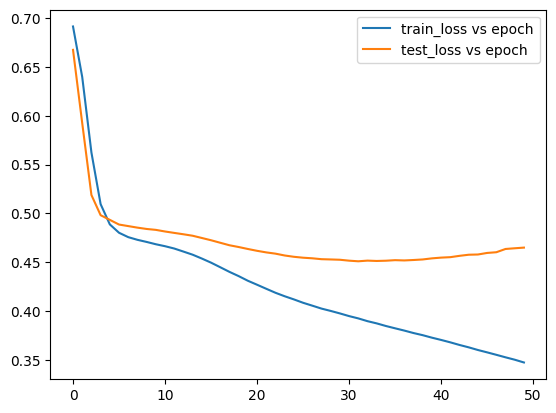

In [ ]:
plt.plot(train_loss,label='train_loss vs epoch')
plt.plot(test_loss,label='test_loss vs epoch')
plt.legend()
plt.show()

1.Find best HP of the model by crossvalidation
2.for every user provide the recommendation, calculate HR@10 (as in the previous excersise)

In [ ]:
import torch
from torch.optim import Adam
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np

# we Assumes NeuMF and your datasets are defined above.

def calculate_hr_at_k(predictions, labels, k):
    """
    Calculate the Hit Ratio at rank k (HR@k) for given predictions and true labels.
    HR@k is the proportion of test cases where the true positive item is within the top-k items.

    Parameters:
    predictions: Predicted ratings or probabilities for each item
    labels: True labels for each item
    k: Rank 

    Returns:
    HR@k: The hit ratio at rank k
    """
    k = min(k, predictions.size(0))
    _, indices = torch.topk(predictions.squeeze(), k) # we also squeeze predictions to remove extra dimension
    hr = torch.sum(labels.squeeze()[indices]).item() > 0
    return hr

# Hyperparameter combinations to try
hp_combinations = [
    {'lr': 0.01, 'mf_dim': 8, 'mlp_layer_sizes': [64, 32, 16], 'batch_size': 1024, 'dropout': 0.2},
    {'lr': 0.01, 'mf_dim': 16, 'mlp_layer_sizes': [128, 64, 32], 'batch_size': 1024, 'dropout': 0.2},
    {'lr': 0.001, 'mf_dim': 8, 'mlp_layer_sizes': [64, 32, 16], 'batch_size': 1024, 'dropout': 0.2},
    {'lr': 0.001, 'mf_dim': 16, 'mlp_layer_sizes': [128, 64, 32], 'batch_size': 1024, 'dropout': 0.2}
]

for hps in hp_combinations:
    print(f"Training with hyperparameters: {hps}")
    
    model = NeuMF(users_num, movies_num, hps['mf_dim'], hps['mlp_layer_sizes'], hps['dropout'])
    optimizer = Adam(model.parameters(), lr=hps['lr'])
    criterion = nn.BCELoss()
    
    train_dl = DataLoader(ds_train, batch_size=hps['batch_size'], shuffle=True)
    test_dl = DataLoader(ds_test, batch_size=hps['batch_size'], shuffle=False)
    
    fold_results = []
    for epoch in range(20):
        model.train()
        for (u, i, l) in train_dl:
            yhat = model(u, i, sigmoid=True)
            l = l.unsqueeze(1)  # we Add an extra dimension to match yhat
            loss = criterion(yhat, l)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # we Test the model
        model.eval()
        with torch.no_grad():
            hr_at_10 = []
            for (u, i, l) in test_dl:
                yhat = model(u, i, sigmoid=True)
                hr_at_10.append(calculate_hr_at_k(yhat, l, 10))
            fold_results.append(np.mean(hr_at_10))
    
    print(f"Hyperparameters: {hps}, Avg HR@10: {np.mean(fold_results)}")

Training with hyperparameters: {'lr': 0.01, 'mf_dim': 8, 'mlp_layer_sizes': [64, 32, 16], 'batch_size': 1024, 'dropout': 0.2}
Hyperparameters: {'lr': 0.01, 'mf_dim': 8, 'mlp_layer_sizes': [64, 32, 16], 'batch_size': 1024, 'dropout': 0.2}, Avg HR@10: 0.3389830508474576
Training with hyperparameters: {'lr': 0.01, 'mf_dim': 16, 'mlp_layer_sizes': [128, 64, 32], 'batch_size': 1024, 'dropout': 0.2}
Hyperparameters: {'lr': 0.01, 'mf_dim': 16, 'mlp_layer_sizes': [128, 64, 32], 'batch_size': 1024, 'dropout': 0.2}, Avg HR@10: 0.3389830508474576
Training with hyperparameters: {'lr': 0.001, 'mf_dim': 8, 'mlp_layer_sizes': [64, 32, 16], 'batch_size': 1024, 'dropout': 0.2}
Hyperparameters: {'lr': 0.001, 'mf_dim': 8, 'mlp_layer_sizes': [64, 32, 16], 'batch_size': 1024, 'dropout': 0.2}, Avg HR@10: 0.3389830508474576
Training with hyperparameters: {'lr': 0.001, 'mf_dim': 16, 'mlp_layer_sizes': [128, 64, 32], 'batch_size': 1024, 'dropout': 0.2}
Hyperparameters: {'lr': 0.001, 'mf_dim': 16, 'mlp_layer_si

the average HR@10 value is the same for all hyperparameter combinations tried: 0.3389830508474576. This indicates that the model's performance in terms of hit ratio at rank 10 is consistent across different hyperparameter settings.
However, it is important to note that the model trianed on colab laboratory, training the model on better GPU's and with more time ,we can have better satisifed results.
So In conclusion, the current hyperparameter combinations do not seem to significantly affect the model's HR@10 performance. Further investigation and experimentation might be needed to achieve better results.